***Reference:***

***Raschka, Sebastian; Liu, Yuxi (Hayden); Mirjalili, Vahid. Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python. Packt Publishing.*** 

# ***<u>Chapter 6</u>***

## ***Learning Best Practices for Model Evaluation & Hyperparameter Tuning***

## Index

- [Streamlining workflows with pipelines](#Streamlining-workflows-with-pipelines)
- [Combining transformers and estimators in a pipeline](#Combining-transformers-and-estimators-in-a-pipeline)
- [Using k-fold Cross Validation to assess model performance](#Using-k---fold-Cross-Validation-to-assess-model-performance)
    - [The Holdout Method](#The-Holdout-Method)
    - [K-fold cross-validation](#K-fold-cross-validation)
        - [Leave-one-out cross-validation](#Leave-one-out-cross-validation)
        - [Stratified k-fold CV](#Stratified-k-fold-CV)
- [Debugging algorithms with learning curves](#Diagnosing-bias-and-variance-problems-with-Learning-Curves)
- [Addressing over- and underfitting with validation curves](#Addressing-over--and-underfitting-with-validation-curves)
- [Tuning hyperparameters via Grid Search](#Tuning-hyperparameters-via-Grid-Search)
- [Tuning hyperparameters via Randomized Search](#Tuning-hyperparameters-via-Randomized-Search)
- [Successive Halving - resource efficient hyperparameter search](#Successive-Halving---resource-efficient-hyperparameter-search)
- [Algorithm selection with nested cross-validation](#Algorithm-selection-with-nested-cross-validation)
- [Looking at different performance evaluation metrics](#Looking-at-different-performance-evaluation-metrics)
    - [Confusion Matrix](#Confusion-Matrix)
    - [Optimizing the precision and recall of a classification model](#Optimizing-the-precision-and-recall-of-a-classification-model)
    - [Plotting a ROC curve](#Plotting-a-ROC-curve)
- [Dealing with class imbalance](#Dealing-with-class-imbalance)
- [Summary](#Summary)

## Streamlining workflows with pipelines 

```Pipeline``` class in scikit-learn. It allows us to fit a model including an arbitrary number of transformation steps and apply it to make predictions about new data.

In [1]:
# Loading the Breast Cancer Wisconsin dataset
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# Encoding the class labels: B->0, M->1

from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:,1].values

le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [4]:
# checking the label mapping
le.transform(['M','B'])

array([1, 0])

In [5]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                    stratify=y,
                                                   random_state=1) 

## Combining transformers and estimators in a pipeline

In [6]:
# to standardize the data
from sklearn.preprocessing import StandardScaler
# dimentionality reduction
from sklearn.decomposition import PCA
# feeding the data to a linear classifier, Logistic Reg
from sklearn.linear_model import LogisticRegression

# Combining above steps into a pipeline
from sklearn.pipeline import make_pipeline


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression())

pipe_lr.fit(X_train, y_train)

y_pred = pipe_lr.predict(X_test)

test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.956


<div>
<img src="Images/pipeline.png" style="width: 500px;"/>
</div>

## Using k-fold Cross Validation to assess model performance

- ***Holdout Cross-Validation***
- ***k-fold Cross-Validation***

### The Holdout Method

- Tuning and comparing different parameter settings to further improve the performance for making predictions on unseen data. This process is called **model selection**.


<div>
<img src="Images/train_val_test_set.png" style="width: 400px;"/>
</div>


- A disadvantage of the holdout method is that the performance estimate may be very sensitive to how we partition the training dataset into the training and validation subsets; the estimate will vary for different examples of the data.

## K-fold cross-validation

- **In k-fold cross-validation, we randomly split the training dataset into k folds without replacement. Here, k – 1 folds, the so-called training folds, are used for the model training, and one fold, the so-called test fold, is used for performance evaluation. This procedure is repeated k times so that we obtain k models and performance estimates.**

- Typically, we use k-fold cross-validation for model tuning, i.e., finding the optimal hyperparameter values that yield a satisfying generalization performance.

- Once we have satisfactory hyperparameter values, we can retrain the model on the complete training dataset and obtain a final performance estimate using the independent test dataset.


For k = 10 folds,<br>
Also, the estimated performances, $E_i$ (for example, classification accuracy or error), for each fold are then used to calculate the estimated average performance, $E$, of the model:
<div>
<img src="Images/k_fold.png" style="width: 500px;"/>
</div>


- ***k=10 folds is a good standard in k-fold cv, which offers best tradeoff  b/w    bias & variance.***

- ***However, for smaller datasets, increase the k value & for larger datasets, decrese the k value.***

### Leave-one-out cross-validation 

A special case of k-fold cross-validation is the leave-one-out cross-validation (LOOCV) method. In LOOCV, we set the number of folds equal to the number of training examples (k = n) so that only one training example is used for testing during each iteration, which is a ***recommended approach for working with very small datasets.***

#### Stratified k-fold CV

A slight improvement over the standard k-fold cross-validation approach is **stratified k-fold cross-validation**, which can yield better bias and variance estimates, especially **in cases of unequal class proportions**. 


In stratified cross-validation, the class label proportions are preserved in each fold to ensure that each fold is representative of the class proportions in the training dataset.

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []

for k, (train,test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    
    print(f'Fold: {k+1:02d}, '
          f'Class distr.: {np.bincount(y_train[train])}, '
          f'Acc.: {score:.3f}')
    
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')

Fold: 01, Class distr.: [256 153], Acc.: 0.935
Fold: 02, Class distr.: [256 153], Acc.: 0.935
Fold: 03, Class distr.: [256 153], Acc.: 0.957
Fold: 04, Class distr.: [256 153], Acc.: 0.957
Fold: 05, Class distr.: [256 153], Acc.: 0.935
Fold: 06, Class distr.: [257 153], Acc.: 0.956
Fold: 07, Class distr.: [257 153], Acc.: 0.978
Fold: 08, Class distr.: [257 153], Acc.: 0.933
Fold: 09, Class distr.: [257 153], Acc.: 0.956
Fold: 10, Class distr.: [257 153], Acc.: 0.956

CV accuracy: 0.950 +/- 0.014


Although the previous code example was useful to illustrate how k-fold cross-validation works, scikit-learn also implements a k-fold cross-validation scorer, which allows us to evaluate our model using stratified k-fold cross-validation less verbosely:

In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)

print(f'CV accuracy scores: {scores}')

print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


by setting ```n_jobs=2```, we distribute the 10 rounds of cross-validation to two CPUs, and by setting ```n_jobs=-1```, we can use all available CPUs on our machine to do the computation in parallel.

## Debugging algorithms with learning curves

- Two very simple diagnostic tools that can help us to improve the performance of a learning algorithm: 
   - **learning curves** and 
   - **validation curves** 
<br>
</br>
- ***Learning curves can help to diagnose whether a learning algorithm has a problem with overfitting (high variance) or underfitting (high bias).*** 

- ***Validation curves can help to address the common issues of learning algorithms.***

### Diagnosing bias and variance problems with *Learning Curves*

- Collecting more training examples to reduce the degree of overfitting.

- ***By plotting the model training and validation accuracies as functions of the training dataset size, we can easily detect whether the model suffers from high variance or high bias, and whether the collection of more data could help to address this problem.***

<div>
<img src="Images/learning_curves.png" style="width: 500px;"/>
</div>


- The graph in the upper left shows a model with a high bias. This model has both low training and cross-validation accuracy, which indicates that it underfits the training data. 
    - Common ways to address this issue are to increase the # of model parameters, for example, by collecting or constructing additional features, or by decreasing the degree of regularization, for example, in SVM or logistic regression classifiers. 

- The graph in the upper-right shows a model that suffers from high variance, which is indicated by the large gap between the training and cross-validation accuracy. 
    - To address this problem of overfitting, we can collect more training data, reduce the complexity of the model, or increase the regularization parameter, for example. 
    
    - For unregularized models, it can also help to decrease the number of features via feature selection (Chapter 4) or feature extraction (Chapter 5) to decrease the degree of overfitting. 
    
    - While collecting more training data usually tends to decrease the chance of overfitting, it may not always help, for example, if the training data is extremely noisy or the model is already very close to optimal.

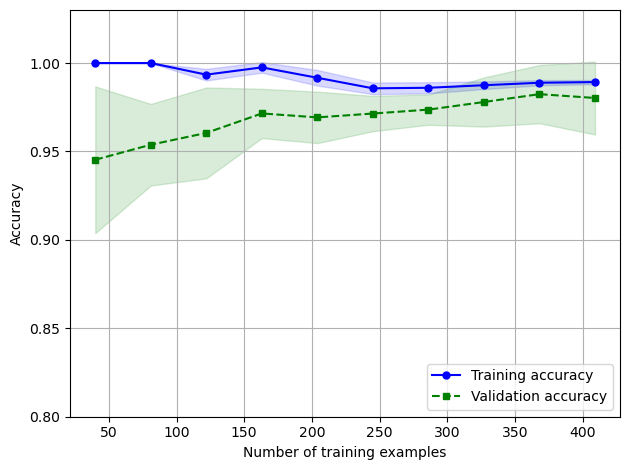

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', max_iter=10000))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                        cv=10,
                                        n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show();

As we can see, our model performs quite well on both the training and validation datasets if it has seen more than 250 examples during training. We can also see that the training accuracy increases for training datasets with fewer than 250 examples, and the gap between validation and training accuracy widens—an indicator of an increasing degree of overfitting.

### Addressing over- and underfitting with validation curves

Validation curves are a useful tool for improving the performance of a model by addressing issues such as overfitting or underfitting. Validation curves are related to learning curves, but instead of plotting the training and test accuracies as functions of the sample size, we vary the values of the model parameters, for example, the inverse regularization parameter, ```C```, in logistic regression.

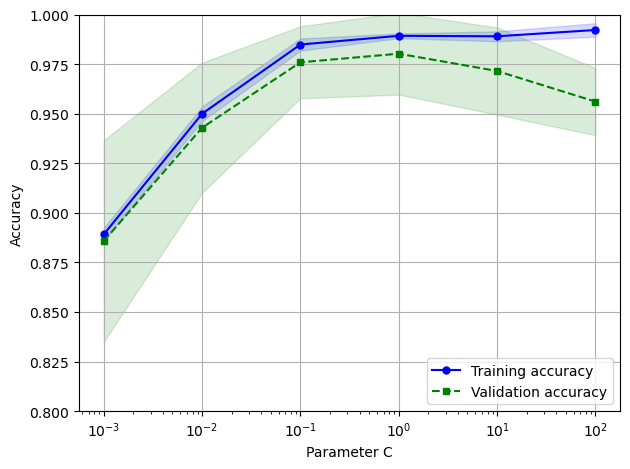

In [10]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr, 
                                             X=X_train, 
                                             y=y_train, 
                                             param_name='logisticregression__C', 
                                             param_range=param_range,
                                             cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show();

Although the differences in the accuracy for varying values of ```C``` are subtle, we can see that the model slightly underfits the data when we increase the regularization strength (small values of ```C```). However, for large values of ```C```, it means lowering the strength of regularization, so the model tends to slightly overfit the data. In this case, the sweet spot appears to be between 0.01 and 0.1 of the ```C``` value.

## Tuning hyperparameters via Grid Search

The grid search approach is quite simple: it’s a brute-force exhaustive search paradigm where we specify a list of values for different hyperparameters, and the computer evaluates the model performance for each combination to obtain the optimal combination of values from this set:

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range,'svc__kernel': ['linear']},
        {'svc__C': param_range,'svc__gamma': param_range,'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  refit=True,
                  n_jobs=-1)

gs = gs.fit(X_train,y_train)

# to get the best score
print(gs.best_score_)

# to get the best parameters
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [12]:
# re-training our dataset on best params
clf = gs.best_estimator_
clf.fit(X_train,y_train)

print(f"Test accuracy: {clf.score(X_test, y_test)}")

Test accuracy: 0.9736842105263158


In [13]:
# using refit=True directly trains our dataset on the best parameters
gs.score(X_test,y_test)

0.9736842105263158

We set the param_grid parameter of ```GridSearchCV``` to a list of dictionaries to specify the parameters that we’d want to tune. 


For the linear SVM, we only evaluated the inverse regularization parameter, ```C```; for the radial basis function (RBF) kernel SVM, we tuned both the ```svc__C``` and ```svc__gamma``` parameters. Note that the ```svc__gamma``` parameter is specific to kernel SVMs. 


Please note that fitting a model with the best settings (```gs.best_estimator_```) on the training set manually via ```clf.fit(X_train, y_train)``` after completing the grid search is not necessary. The ```GridSearchCV``` class has a ```refit``` parameter, which will refit the ```gs.best_estimator_``` to the whole training set automatically if we set ```refit=True``` (default).

## Tuning hyperparameters via Randomized Search

- Since grid search is an exhaustive search, it is guaranteed to find the optimal hyperparameter configuration if it is contained in the user-specified parameter grid. *However, specifying large hyperparameter grids makes grid search very expensive in practice.* 

- An alternative approach for sampling different parameter combinations is randomized search. ***In randomized search, we draw hyperparameter configurations randomly from distributions(or discrete sets).*** 

- In contrast to grid search, randomized search does not do an exhaustive search over the hyperparameter space. Still, it allows us to explore a wider range of hyperparameter value settings in a more cost- and time-effective manner. 

- This concept is illustrated in Figure 6.7, which shows a fixed grid of nine hyperparameter settings being searched via grid search and randomized search: 


<div>
<img src="Images/randomized_search.png" style="width: 500px;"/>
</div>


- ***The main takeaway is that while grid search only explores discrete, user-specified choices, it may miss good hyperparameter configurations if the search space is too scarce.***

The main difference b/w ```GridSearchCV``` & ```RandomizedSearchCV``` is that we can specify distributions as part of our parameter grid and specify the total number of hyperparameter configurations to be evaluated.

In [14]:
# RandomizedSearchCV using discrete param values

from sklearn.model_selection import RandomizedSearchCV


pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

# Using previous param range
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range,'svc__kernel': ['linear']},
              {'svc__C': param_range,'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]


rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9737681159420291
{'svc__kernel': 'rbf', 'svc__gamma': 0.001, 'svc__C': 10.0}


In [16]:
import scipy.stats

# Using a distribution
param_range = scipy.stats.loguniform(0.0001, 1000.0)

np.random.seed(1)

# drawing 10 random samples from the above distribution using rvs() method
param_range.rvs(10)

array([8.30145146e-02, 1.10222804e+01, 1.00184520e-04, 1.30715777e-02,
       1.06485687e-03, 4.42965766e-04, 2.01289666e-03, 2.62376594e-02,
       5.98924832e-02, 5.91176467e-01])

In [17]:
# RandomizedSearchCV using a distribution of param values

from sklearn.model_selection import RandomizedSearchCV


pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

# Using a distribution
param_range = scipy.stats.loguniform(0.0001, 1000.0)


param_grid = [{'svc__C': param_range,'svc__kernel': ['linear']},
              {'svc__C': param_range,'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]


rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9780676328502416
{'svc__C': 0.05971247755848464, 'svc__kernel': 'linear'}


## Successive Halving - resource efficient hyperparameter search

Taking the idea of randomized search one step further, scikit-learn implements a successive halving variant, ```HalvingRandomSearchCV```, that makes finding suitable hyperparameter configurations more efficient. 

Successive halving, given a large set of candidate configurations, successively throws out unpromising hyperparameter configurations until only one configuration remains. We can summarize the procedure via the following steps:

   1. Draw a large set of candidate configurations via random sampling 
   
   2. Train the models with limited resources, for example, a small subset of the training data (as opposed to using the entire training set) 
   
   3. Discard the bottom 50 percent based on predictive performance 
   
   4. Go back to step 2 with an increased amount of available resources 
   
The steps are repeated until only one hyperparameter configuration remains. Note that there is also a successive halving implementation for the grid search variant called ```HalvingGridSearchCV```, where all specified hyperparameter configurations are used in step 1 instead of random samples.

In [18]:
# enabling HalvingRandomSearchCV in sklearn
from sklearn.experimental import enable_halving_search_cv

# importing it
from sklearn.model_selection import HalvingRandomSearchCV

In [19]:
hs = HalvingRandomSearchCV(pipe_svc,
                           param_distributions=param_grid,
                           n_candidates='exhaust',
                           resource='n_samples',
                           factor=1.5,
                           random_state=1,
                           n_jobs=-1)

hs = hs.fit(X_train, y_train)

print(hs.best_score_)
print(hs.best_params_)

0.9617647058823529
{'svc__C': 4.934834261073341, 'svc__kernel': 'linear'}


In [20]:
clf = hs.best_estimator_
print(f'Test accuracy: {hs.score(X_test, y_test):.3f}')

Test accuracy: 0.982


## Algorithm selection with ***nested cross-validation*** 

- Using k-fold cross-validation in combination with grid search or randomized search is a useful approach for fine-tuning the performance of a machine learning model by varying its hyperparameter values, as we saw in the previous subsections. 

- **If we want to select among different machine learning algorithms,** ***nested cross-validation*** **is recommended. In a nice study on the bias in error estimation, concluded that the true error of the estimate is almost unbiased relative to the test dataset when nested cross-validation is used.**


- In nested cross-validation, we have an outer k-fold cross-validation loop to split the data into training and test folds, and an inner loop is used to select the model using k-fold cross-validation on the training fold. After model selection, the test fold is then used to evaluate the model performance. 

- Figure 6.8 explains the concept of nested cross-validation with only five outer and two inner folds, which can be useful for large datasets where computational performance is important; this particular type of nested cross-validation is also known as 5×2 cross-validation:
<div>
<img src="Images/nested_cv.png" style="width: 400px;"/>
</div>

In [21]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range,'svc__kernel': ['linear']},
              {'svc__C': param_range,'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)

print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy: 0.974 +/- 0.015


The returned average cross-validation accuracy gives us a good estimate of what to expect if we tune the hyperparameters of a model and use it on unseen data. 


For example, we can use the nested cross-validation approach to compare an SVM model to a simple decision tree classifier; for simplicity, we will only tune its depth parameter:

In [22]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)

print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy: 0.934 +/- 0.016


As we can see, the nested cross-validation performance of the SVM model (97.4 percent) is notably better than the performance of the decision tree (93.4 percent), and thus, we’d expect that it might be the better choice to classify new data that comes from the same population as this particular dataset.

## Looking at different performance evaluation metrics

- **Precision**
- **Recall**
- **F1 Score**
- **Matthews correlation coefficient(MCC)**

## Confusion Matrix

A confusion matrix is a matrix that lays out the performance of a learning algorithm. A confusion matrix is simply a square matrix that reports the counts of the **true positive(TP)**, **true negative(TN)**, **false positive(FP)**, and **false negative(FN)** predictions of a classifier,
<div>
<img src="Images/confusion_matrix.png" style="width: 300px;"/>
</div>

In [26]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)

y_pred = pipe_svc.predict(X_test)

confu_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confu_mat)

# The array that was returned after executing the code provides us with
# information about the different types of error the classifier made 
# on the test dataset.

[[71  1]
 [ 2 40]]


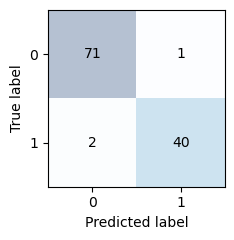

In [28]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.matshow(confu_mat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confu_mat.shape[0]):
    for j in range(confu_mat.shape[1]):
        ax.text(x=j, y=i, s=confu_mat[i, j], va='center', ha='center')
        
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show();

*Assuming that class ```1``` (malignant) is the positive class in this example,*

- **our model correctly classified 71 of the examples that belong to class ```0``` (TN) and** 

- **40 examples that belong to class ```1``` (TP), respectively.** 

- **However, our model also incorrectly misclassified two examples from class ```1``` as class ```0``` (FN),** 

- **and it predicted that one example is malignant although it is a benign tumor (FP).**

Additional Note

Remember that we previously encoded the class labels so that malignant examples are the "postive" class (1), and benign examples are the "negative" class (0):

In [29]:
le.transform(['M', 'B'])

array([1, 0])

Next, we printed the confusion matrix like so:

In [31]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


Note that the (true) class 0 examples that are correctly predicted as class 0 (true negatives) are now in the upper left corner of the matrix (index 0, 0). In order to change the ordering so that the true negatives are in the lower right corner (index 1,1) and the true positves are in the upper left, we can use the labels argument like shown below:

In [32]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
print(confmat)

[[40  2]
 [ 1 71]]


We conclude:

Assuming that class 1 (malignant) is the positive class in this example, our model correctly classified 71 of the examples that belong to class 0 (true negatives) and 40 examples that belong to class 1 (true positives), respectively. However, our model also incorrectly misclassified 1 example from class 0 as class 1 (false positive), and it predicted that 2 examples are benign although it is a malignant tumor (false negatives).

## Optimizing the precision and recall of a classification model


<div align="center">
<img src="Images/confusion_matrix.png" style="width: 300px;"/>
</div>


- The **error(ERR)** can be understood as the sum of all false predictions divided by the number of total predictions, and the **accuracy(ACC)** is calculated as the sum of correct predictions divided by the total number of predictions, respectively:
$$\boxed{\textbf{ERR} = \frac{\text{FP + FN}}{\text{FP + FN + TP + TN}}}$$


$$\boxed{\text{Acurracy} = \textbf{ACC} = \frac{\text{TP + TN}}{\text{FP + FN + TP + TN}} = 1 - \textbf{ERR}}$$


- The **true positive rate (TPR)** and **false positive rate (FPR)** are performance metrics that are especially useful for imbalanced class problems:
$$\boxed{\textbf{FPR} = \frac{FP}{N} = \frac{FP}{FP + TN}}$$

$$\boxed{\textbf{TPR} = \frac{TP}{P} = \frac{TP}{FN + TP}}$$


In tumor diagnosis, for example, we are more concerned about the detection of malignant tumors in order to help a patient with the appropriate treatment. However, it is also important to decrease the number of benign tumors incorrectly classified as malignant (FP) to not unnecessarily concern patients. 

In contrast to the FPR, the TPR provides useful information about the fraction of positive (or relevant) examples that were correctly identified out of the total pool of positives (P). 

- The performance metrics **precision (PRE)** and **recall (REC)** are related to those TP and TN rates, and in fact, REC is synonymous with TPR: $$\boxed{\textbf{REC = TPR}}$$ ***In other words, recall quantifies how many of the relevant records (the positives) are captured as such (the true positives).*** 

- ***Precision quantifies how many of the records predicted as relevant (the sum of true and false positives) are actually relevant (true positives):*** $$\boxed{\textbf{PRE} = \frac{TP}{TP + FP}}$$


Revisiting the malignant tumor detection example, optimizing for recall helps with minimizing the chance of not detecting a malignant tumor. However, this comes at the cost of predicting malignant tumors in patients although the patients are healthy (a high number of FPs). If we optimize for precision, on the other hand, we emphasize correctness if we predict that a patient has a malignant tumor. However, this comes at the cost of missing malignant tumors more frequently (a high number of FNs). 


- **To balance the up- and downsides of optimizing PRE and REC, the harmonic mean of PRE and REC is used, the so-called F1 score:**
$$\boxed{\textbf{F1} = 2\frac{PRE \times REC}{PRE + REC}}$$


Lastly, a measure that summarizes a confusion matrix is the **MCC**, which is especially popular in biological research contexts. The MCC is calculated as follows: 

$$\textbf{MCC} = \frac{TP \times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$

In contrast to PRE, REC, and the F1 score, the MCC ranges between –1 and 1, and it takes all elements of a confusion matrix into account—for instance, the F1 score does not involve the TN. While the MCC values are harder to interpret than the F1 score, it is regarded as a superior metric,

<div align="center">
<img src="Images/confusion_matrix.png" style="width: 300px;"/>
</div>

- ***Sensitivity/Recall/True Positive Rate***: 
    Sensitivity is the conditional probability that the predicted class is positive given that the actual class is  positive.
    $$\text{Recall} = \text{TPR}= \frac{TP}{TP + FN}$$


- ***Specificity(True Negative Rate)***: 
    Specificity is the conditional probability that the predicted class is negative given that the actual class is  negative.
    $$\text{Specificity} = \frac{TN}{TN + FP}$$


- ***Precision***: 
    Precision is the conditional probability that the actual value is positive given that the prediction by the  model is positive.
    $$\text{Presion} = \frac{TP}{TP + FP}$$

 
- ***F-Score***: 
    F-Score is a measure that combines precision and recall (harmonic mean between precision and recall). 
    $$\text{F-Score} = \frac{2 * Recall * Precision}{Recall + Precision}$$


```classification_report()``` method in skearn.metrics gives a detailed report of precision, recall, and F-score  for each class.

In [36]:
from sklearn.metrics import classification_report,\
                            precision_score,\
                            recall_score, f1_score,\
                            matthews_corrcoef


print(classification_report(y_true=y_test, y_pred=y_pred))

# Here, Support is the number of actual occurrences of the class in the specified dataset

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [37]:
pre_val = precision_score(y_true=y_test, y_pred=y_pred)
print(f'Precision: {pre_val:.3f}')

rec_val = recall_score(y_true=y_test, y_pred=y_pred)
print(f'Recall: {rec_val:.3f}')

f1_val = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1: {f1_val:.3f}')

mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print(f'MCC: {mcc_val:.3f}')

Precision: 0.976
Recall: 0.952
F1: 0.964
MCC: 0.943


#### ```make_scorer``` function

**Remember that the positive class in scikit-learn is the class that is labeled as class ```1```. If we want to specify a different positive label, we can construct our own scorer via the ```make_scorer``` function, which we can then directly provide as an argument to the ```scoring``` parameter in ```GridSearchCV``` (in this example, using the ```f1_score``` as a metric):**

In [38]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


## Plotting a ROC curve

- **Receiver operating characteristic (ROC)** *graphs are useful tools to select models for classification based on their performance with respect to the FPR and TPR, which are computed by shifting the decision threshold of the classifier.* 

- ***The diagonal of a ROC graph can be interpreted as random guessing, and classification models that fall below the diagonal are considered as worse than random guessing.*** 

- ***A perfect classifier would fall into the top-left corner of the graph with a TPR of 1 and an FPR of 0.*** 

- *Based on the ROC curve, we can then compute the so-called* **ROC area under the curve (ROC AUC)** *to characterize the performance of a classification model.* 

- Similar to ROC curves, we can compute precision-recall curves for different probability thresholds of a classifier. A function for plotting those precision-recall curves is also implemented in scikit-learn and is documented at http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred)

0.9692460317460317

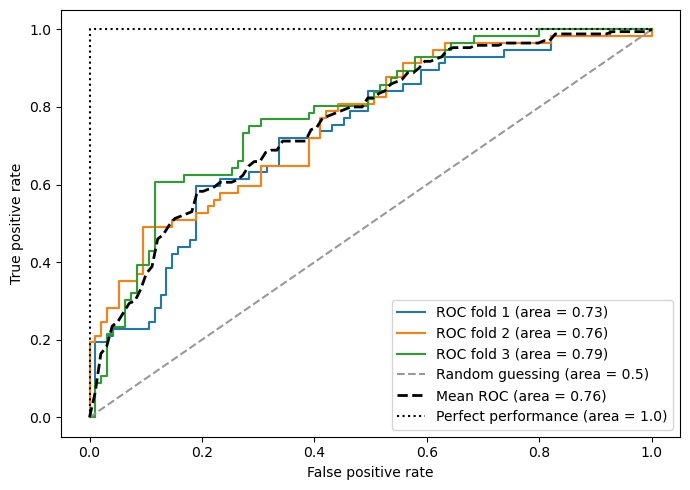

In [39]:
from sklearn.metrics import roc_curve, auc
from numpy import interp


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

# only using 2 features from the dataset
X_train2 = X_train[:, [4, 14]]
    
# using 3 fold cv
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing (area = 0.5)')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance (area = 1.0)')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show();

### The scoring metrics for multiclass classification

In [44]:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')

## Dealing with class imbalance

For instance, our priority might be to identify the majority of patients with malignant cancer to recommend an additional screening, so recall should be our metric of choice. In spam filtering, where we don’t want to label emails as spam if the system is not very certain, precision might be a more appropriate metric.


One way to deal with imbalanced class proportions during model fitting is to assign a larger penalty to wrong predictions on the minority class. Via scikit-learn, adjusting such a penalty is as convenient as setting the ```class_weight``` parameter to ```class_weight='balanced'```, which is implemented for most classifiers.


Other popular strategies for dealing with class imbalance include upsampling the minority class, downsampling the majority class, and the generation of synthetic training examples.

In [45]:
# creating an unbalanced data from orginal dataset,
# where 90% of the data belongs to class 0(B benign tumors)

# So, if calculate the accuracy of a model, we would achieve a prediction
# accuracy of close to 90%, which would mean our model hasn’t learned 
# anything useful from the features provided in this dataset.


X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [46]:
# prediction
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [47]:
# Upsampling

from sklearn.utils import resample

print('Number of class 1 examples before:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])

Number of class 1 examples before: 40
Number of class 1 examples after: 357


In [48]:
# balanced data
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

# prediction on balanced data
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

Another technique to generate new training data to address class imbalance:
**SMOTE(Synthetic Minority Oversampling Technique)**

## Summary

- **Pipeline:** to chain different transformation techniques and classifiers that help us to train and evaluate machine learning models more efficiently. 

- **k-fold cross-validation, for model selection and evaluation.** 
- Using k-fold cross-validation, we plot learning and validation curves to overcome overfitting and underfitting. 

- Using grid search, randomized search, and successive halving -- fine-tuned our model. 

- confusion matrices and various performance metrics(precision, recall, f1-score, roc_auc_score) to evaluate and optimize a model’s performance for specific problem tasks. 

- dealing with imbalanced data

Now, you should be well equipped with the essential techniques to build supervised machine learning models for classification successfully.

***Reference:***

***Raschka, Sebastian; Liu, Yuxi (Hayden); Mirjalili, Vahid. Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python. Packt Publishing.*** 